<a href="https://colab.research.google.com/github/DawidP2001/MLPortfolio/blob/main/DecisionTrees_IncomePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


# **1. Introudction**
In this project I'm going to show how I use decision trees. The data set i use is Adult census income. It is a collection of records from the 1994 census in the US. You can have a look at the dataset [here](https://www.kaggle.com/datasets/uciml/adult-census-income). In this project I will try to make an algorithm that would be able to predict whether a certain person was earning under or over $50,000 a year based on certain characteristics.

---




#  **2. DataSet**




---


## **2.1 Dataset Download**
Directly below I show how I directly access the data from keggle without downloading it manually onto my local machine first.

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dawidpionk","key":"ca3f41696a489f42942bb464285ea394"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d uciml/adult-census-income

Dataset URL: https://www.kaggle.com/datasets/uciml/adult-census-income
License(s): CC0-1.0
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 68.1MB/s]


In [ ]:
! mkdir adult-census-income
! unzip adult-census-income.zip -d adult-census-income

Archive:  adult-census-income.zip
  inflating: adult-census-income/adult.csv  


Below I just extract the data from the file

In [ ]:
import csv
import pandas as pd
import numpy as np
data = pd.read_csv('adult-census-income/adult.csv')

data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K




---


## **2.2 Data Preprocessing**
Below I Remove all the rows with a missing entry. Only the workclass, occupation and native country had missing entries so I just use the drop method on them.

In [ ]:
def removeEmptyRows(data):
  data.drop(data[data['workclass'] == '?'].index, inplace = True)
  data.drop(data[data['occupation'] == '?'].index, inplace = True)
  data.drop(data[data['native.country'] == '?'].index, inplace = True)
  return data

Below I prepare the data to be used by the algorithm. Since the decision tree algorithm can only use numerical data, I converted all the categorical entries into numerical values inside a map data structure.

### 2.2.1 workclass Column

In [ ]:
data['workclass'].unique() # Check what are the unique values for the
                           # workclass column

array(['?', 'Private', 'State-gov', 'Federal-gov', 'Self-emp-not-inc',
       'Self-emp-inc', 'Local-gov', 'Without-pay', 'Never-worked'],
      dtype=object)

In [ ]:
def convertWorkclass(data):
  # dataToMap stores the map that will replace the entries on the data frame
  dataToMap = {
      'Private': 0,
      'State-gov': 1,
      'Federal-gov': 2,
      'Self-emp-not-inc': 3, # Self-employed, not incorporated
      'Self-emp-inc': 4,     # Self-employed, incorporated
      'Local-gov': 5,
      'Without-pay': 6,
      'Never-worked': 7
      }
  data['workclass'] = data['workclass'].map(dataToMap)
  return data
data = convertWorkclass(data)
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,0.0,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,0.0,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,0.0,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


### 2.2.2 education Column

In [ ]:
data['education'].unique() # Check what are the unique values for the
                           # workclass column

array(['HS-grad', 'Some-college', '7th-8th', '10th', 'Doctorate',
       'Prof-school', 'Bachelors', 'Masters', '11th', 'Assoc-acdm',
       'Assoc-voc', '1st-4th', '5th-6th', '12th', '9th', 'Preschool'],
      dtype=object)

In [ ]:
def convertEducation(data):
  dataToMap = {
      'HS-grad': 0,
      '7th-8th': 1,
      'Some-college': 2,
      '10th': 3,
      'Doctorate': 4,
      'Prof-school': 5,
      'Bachelors': 6,
      'Masters': 7,
      '11th': 8,
      'Assoc-voc': 9,
      '1st-4th': 10,
      '5th-6th': 11,
      'Assoc-acdm': 12,
      '12th': 13,
      '9th': 14,
      'Preschool': 15
      }
  data['education'] = data['education'].map(dataToMap)
  return data
data = convertEducation(data)
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,0,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,0.0,132870,0,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,2,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,0.0,140359,1,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,0.0,264663,2,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


### 2.2.3 Marital Status Column

In [ ]:
data['marital.status'].unique() # Check what are the unique values for the
                                # marital status column

array(['Widowed', 'Divorced', 'Separated', 'Never-married',
       'Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype=object)

In [ ]:
def convertMaritalStatus(data):
  dataToMap = {
      'Widowed': 0,
      'Divorced': 1,
      'Separated': 2,
      'Never-married': 3,
      'Married-civ-spouse': 4,
      'Married-spouse-absent': 5,
      'Married-AF-spouse': 6
      }
  data['marital.status'] = data['marital.status'].map(dataToMap)
  return data
data = convertMaritalStatus(data)
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,0,9,0,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,0.0,132870,0,9,0,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,2,10,0,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,0.0,140359,1,4,1,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,0.0,264663,2,10,2,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


### 2.2.4 Sex Column

In [ ]:
data['sex'].unique() # Check what are the unique values for the
                     # sex column

array(['Female', 'Male'], dtype=object)

In [ ]:
def convertSex(data):
  dataToMap = {
      'Female': 0,
      'Male': 1,
      }
  data['sex'] = data['sex'].map(dataToMap)
  return data
data = convertSex(data)
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,0,9,0,?,Not-in-family,White,0,0,4356,40,United-States,<=50K
1,82,0.0,132870,0,9,0,Exec-managerial,Not-in-family,White,0,0,4356,18,United-States,<=50K
2,66,NaN,186061,2,10,0,?,Unmarried,Black,0,0,4356,40,United-States,<=50K
3,54,0.0,140359,1,4,1,Machine-op-inspct,Unmarried,White,0,0,3900,40,United-States,<=50K
4,41,0.0,264663,2,10,2,Prof-specialty,Own-child,White,0,0,3900,40,United-States,<=50K


### 2.2.5 Income Column

In [ ]:
data['income'].unique() # Check what are the unique values for the
                        # income column

array(['<=50K', '>50K'], dtype=object)

In [ ]:
def convertIncome(data):
  dataToMap = {
      '<=50K': 0,
      '>50K': 1,
      }
  data['income'] = data['income'].map(dataToMap)
  return data
data = convertIncome(data)
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,0,9,0,?,Not-in-family,White,0,0,4356,40,United-States,0
1,82,0.0,132870,0,9,0,Exec-managerial,Not-in-family,White,0,0,4356,18,United-States,0
2,66,NaN,186061,2,10,0,?,Unmarried,Black,0,0,4356,40,United-States,0
3,54,0.0,140359,1,4,1,Machine-op-inspct,Unmarried,White,0,0,3900,40,United-States,0
4,41,0.0,264663,2,10,2,Prof-specialty,Own-child,White,0,0,3900,40,United-States,0


###2.2.6 Prepare The Data function

In [ ]:
# This function prepares data for making a decision tree
def prepareData(data):
  data = removeEmptyRows(data)
  data = convertWorkclass(data)
  data = convertEducation(data)
  data = convertMaritalStatus(data)
  data = convertSex(data)
  data = convertIncome(data)
  return data



---


<a name="Decision-Tree-Algorithm-Section"></a>
# **3. Decision Tree Algorithm**
Decision Tree is a machine learning model in which the data is split into smaller subsets based on certain criteria depending on the model. This process is repeated over and over again until you can't reduce the data anymore.

Decision Trees can be used for both classification and regression tasks. **Classification Task** is when you try to predict a **categorical value**. **Regressiion Task** is when you try to predict a **continuous value**. Since I am trying to predict whether a person earns more or less than 50k I am working on a classifcation task.

To learn about this subject I used the following resources: [w3schools](https://www.w3schools.com/python/python_ml_decision_tree.asp), chatGPT

Below I show how I use a decision tree algorithm on my dataset. For this task I used the scikit-learn library, which implements a decision tree type called CART.


### 3.1 Decision Tree setup and data Visualisation

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

[Text(0.5288461538461539, 0.9, 'marital.status <= 3.5\ngini = 0.366\nsamples = 32561\nvalue = [24720, 7841]'),
 Text(0.3076923076923077, 0.7, 'marital.status <= 1.5\ngini = 0.121\nsamples = 17144\nvalue = [16039, 1105]'),
 Text(0.4182692307692308, 0.8, 'True  '),
 Text(0.15384615384615385, 0.5, 'sex <= 0.5\ngini = 0.181\nsamples = 5436\nvalue = [4888, 548]'),
 Text(0.07692307692307693, 0.3, 'marital.status <= 0.5\ngini = 0.12\nsamples = 3497\nvalue = [3272.0, 225.0]'),
 Text(0.038461538461538464, 0.1, 'gini = 0.105\nsamples = 825\nvalue = [779, 46]'),
 Text(0.11538461538461539, 0.1, 'gini = 0.125\nsamples = 2672\nvalue = [2493.0, 179.0]'),
 Text(0.23076923076923078, 0.3, 'marital.status <= 0.5\ngini = 0.278\nsamples = 1939\nvalue = [1616, 323]'),
 Text(0.19230769230769232, 0.1, 'gini = 0.357\nsamples = 168\nvalue = [129, 39]'),
 Text(0.2692307692307692, 0.1, 'gini = 0.269\nsamples = 1771\nvalue = [1487, 284]'),
 Text(0.46153846153846156, 0.5, 'sex <= 0.5\ngini = 0.091\nsamples = 11708\

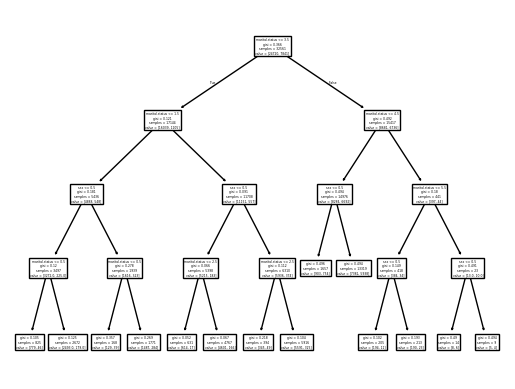

In [ ]:
import pandas
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# features are the categories that the model will be trained on.
features = ['marital.status', 'sex']

X = data[features]
y = data['income']

dtree = DecisionTreeClassifier()
dtree = dtree.fit(X, y)

tree.plot_tree(dtree, feature_names=features)

As you can see the ouput from the plot is too small to read. So below I try out different methods to try to make the nodes more visible

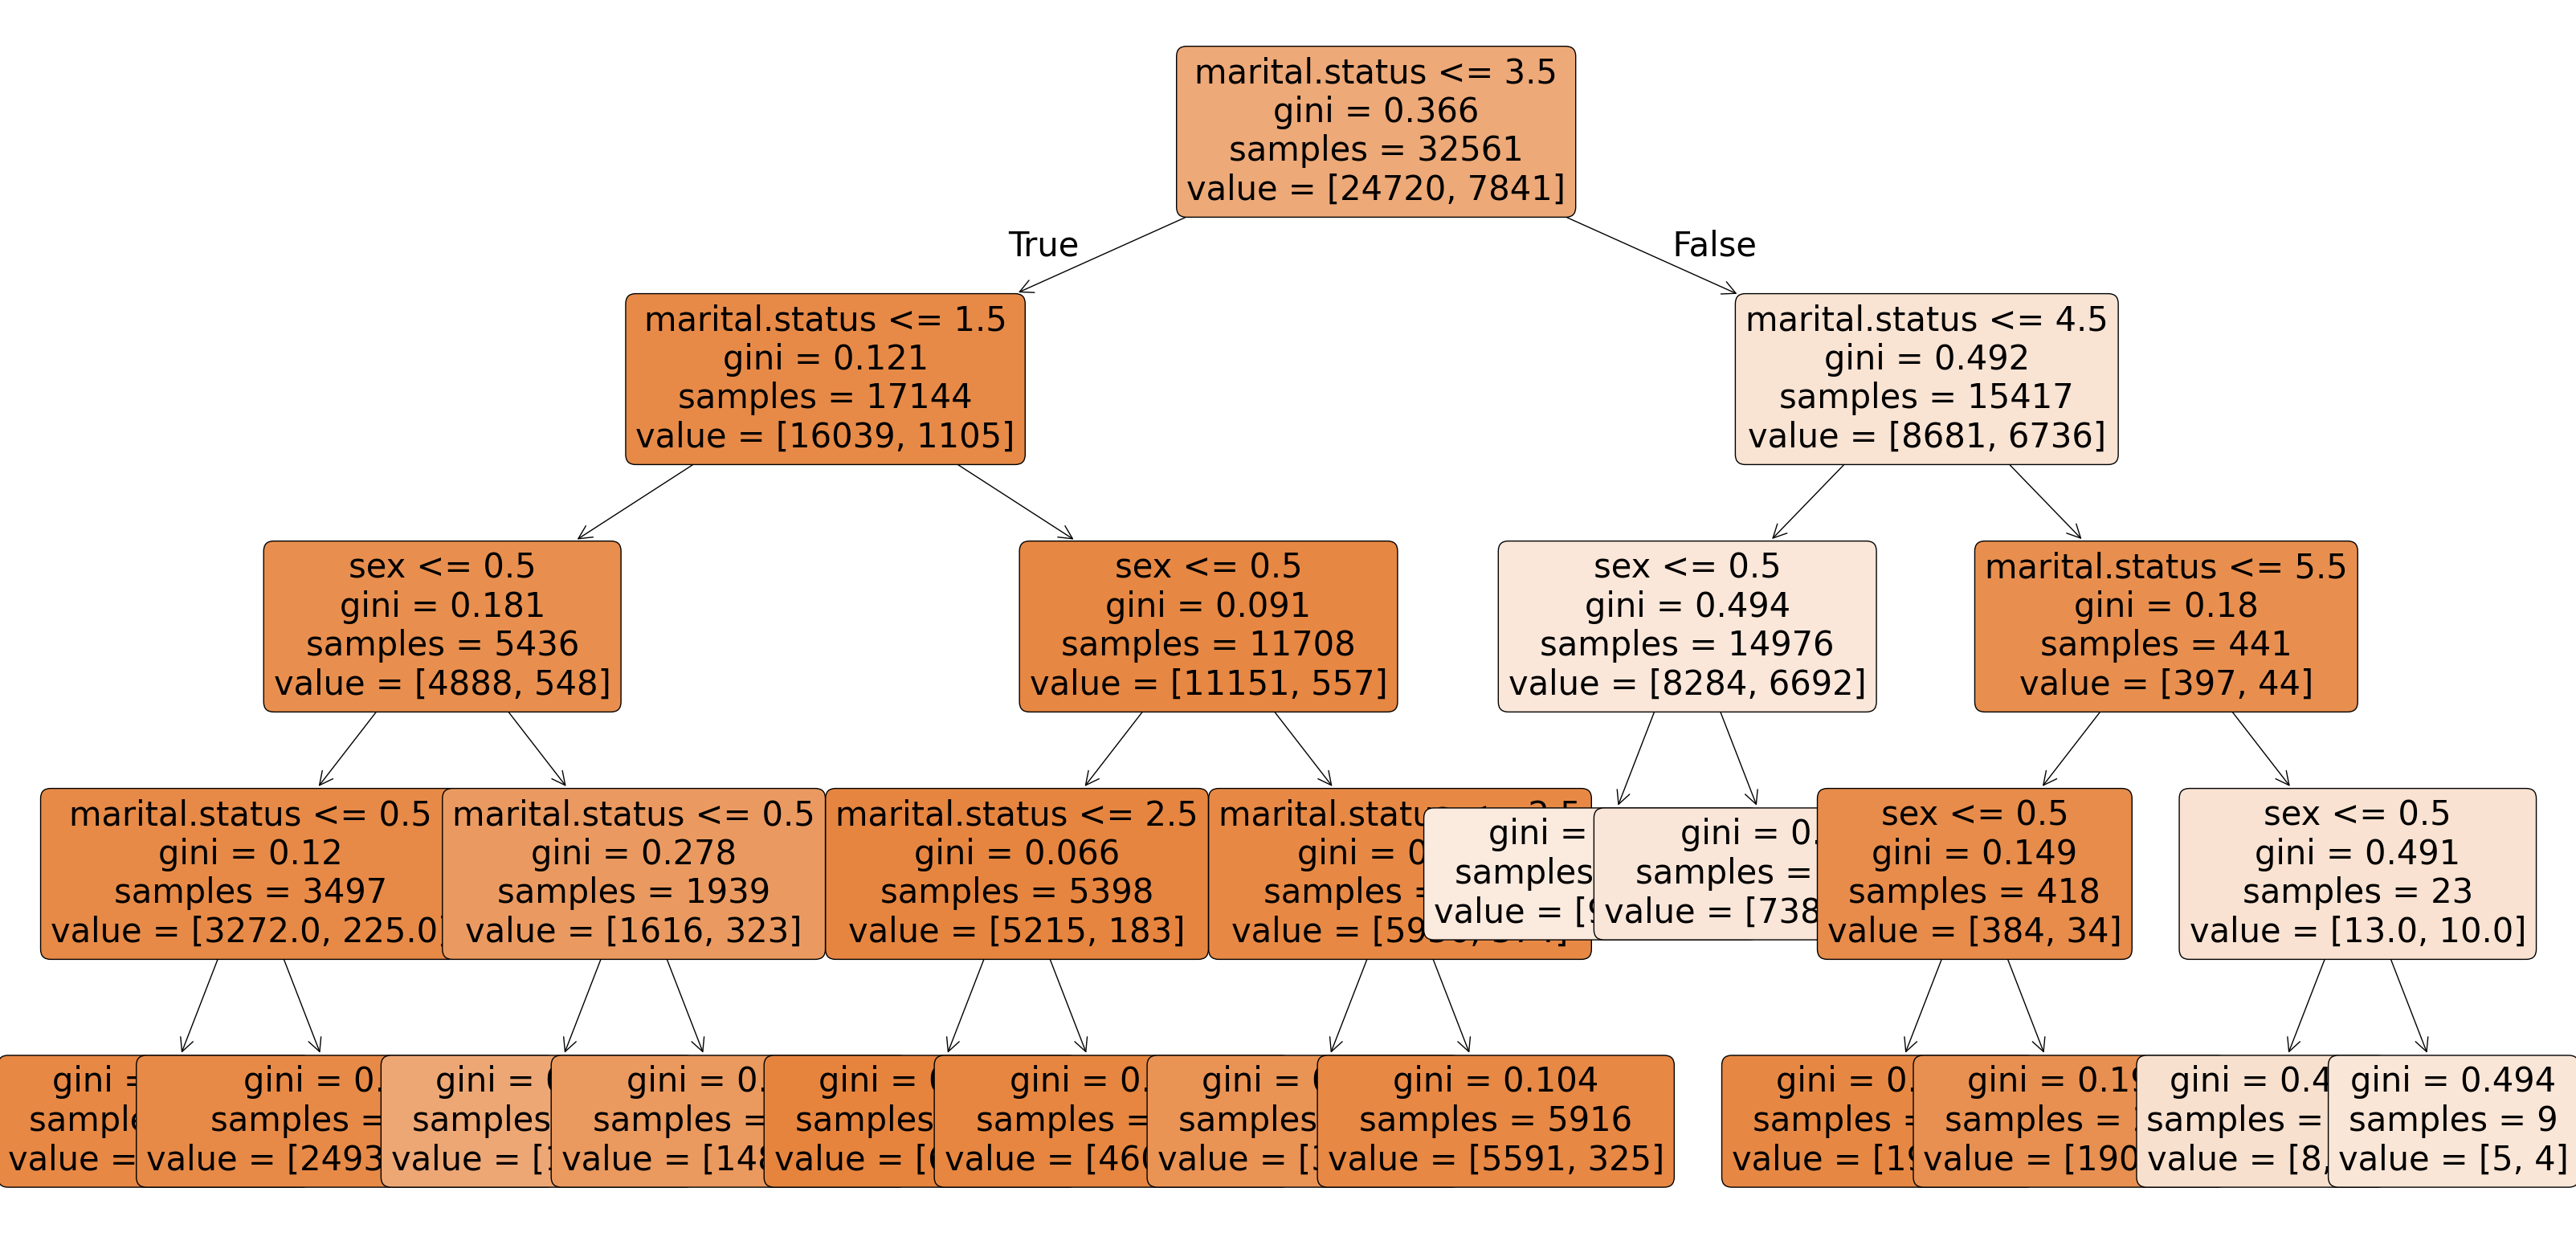

In [ ]:
plt.figure(figsize=(40, 20))  # Adjust width and height as needed
tree.plot_tree(
    dtree,
    feature_names=features,
    filled=True,
    rounded=True,
    fontsize=30
    )
plt.show()

As you can see above the graph is still pretty squished. When I try to make the graph larger the nodes themseleves become smaller and more difficult to read, so I assume this an issue with juptyter notebook and how it displays larger charts.

### 3.2 Predictions and accuracy

Below I try to figure out how to gauge how accurate the model above is. I used the following source for this section: [datacamp](https://www.datacamp.com/tutorial/decision-tree-classification-python?dc_referrer=https%3A%2F%2Fwww.google.com%2F)

In [ ]:
from sklearn import metrics
y_pred = dtree.predict(X)
print("Accuracy:",metrics.accuracy_score(y, y_pred))

Accuracy: 0.7591904425539756


The accuracy is 75% which is a pretty good accuracy, so the model is quite useful at predicting whether an adults income is above 50k. How I could potentially make the model accurate is by adding additional x variables. As you can see in the preprocessing section I made the columns workclass and education suitable to be used for model training. Below I add those additional variables to see if it could potentially increase the accuracy of this model.

In [ ]:
# as you can see I added workforce and education to the independent variables
features = ['workclass', 'education', 'marital.status', 'sex']

X = data[features]
y = data['income']

dtree = DecisionTreeClassifier()
dtree = dtree.fit(X, y)
y_pred = dtree.predict(X)
print("Accuracy:",metrics.accuracy_score(y, y_pred))

Accuracy: 0.8278001289886674


As you can see addition of those 2 variables increased the accuracy quite significantly, from 75% to 82%.



---


# **4. Testing Sets**
In this section I try to learn how the concept of Test sets works in data science. I used this resource for this purpose: [w3schools](https://www.w3schools.com/python/python_ml_train_test.asp).

Below I set up a scatter graph with 2 random variables just to visually show the difference between the full data, testing data and training data sets.

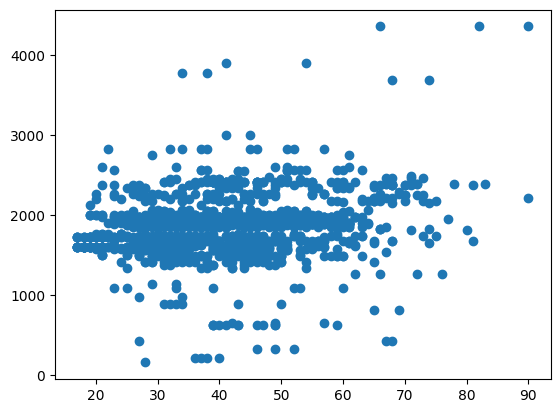

In [ ]:
data = pd.read_csv('adult-census-income/adult.csv')
processedData = data[data['capital.loss']>0] # Just removed all the rows that
                                             # had no capital loss
x = processedData['age']
y = processedData['capital.loss']
plt.scatter(x, y)

Train/Test is a method in machine learning in which you split your data set into to groups, the training set and testing set. The training set is 80% of your overall data and is responsible for training your model, meanwhile testing data is 20% of your overall data and is responsible for testing if your model was trained correctly.
Below you can see how I tried out this concept.

In [ ]:
print(x.count())

1519


As you can see above there are 1519 rows in my dataset. So 1215 rows should be within the training set and 304 should be within the testing set.

In [ ]:
train_x = x[:1215]
train_y = y[:1215]

test_x = x[1215:]
test_y = y[1215:]
print(train_x.count())
print(test_x.count())

1215
304


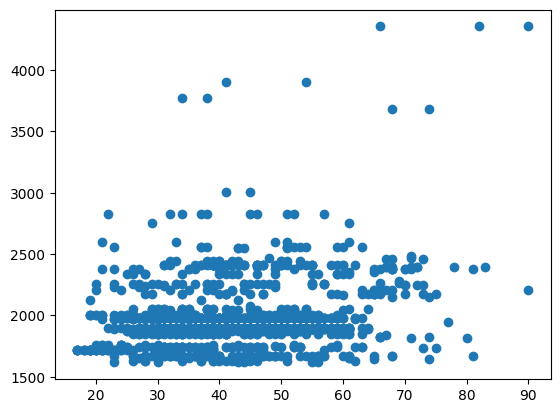

In [ ]:
plt.scatter(train_x, train_y)
plt.show()

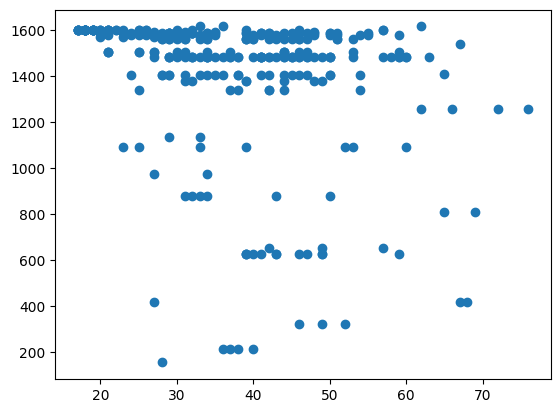

In [ ]:
plt.scatter(test_x, test_y)
plt.show()

Above you can see the difference between the two sets. Also you can see that the data is very different in the two graphs. The data in the training set only contains values above rougly 2000 while in the tesing set its all under 2000, which suggests the data was sorted. This issue can probably be fixed by randomising the set, below I attempt this to see if it fixed the issues.

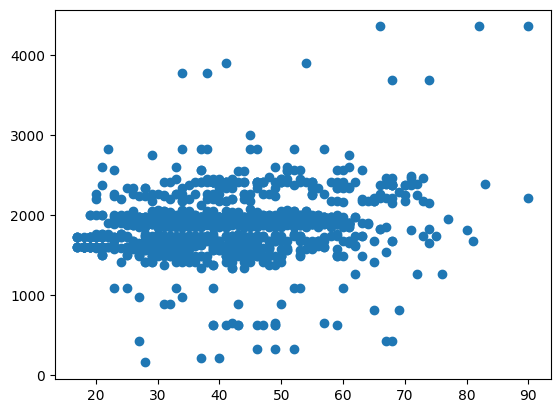

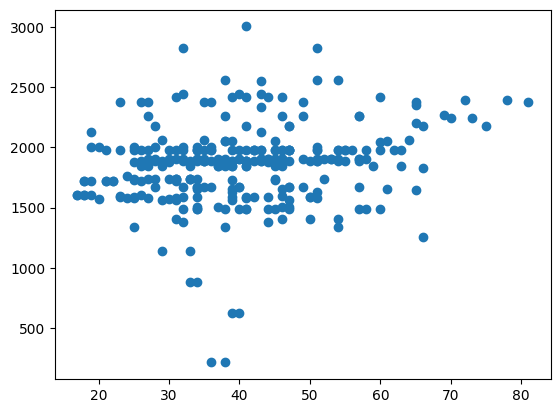

In [ ]:
data = pd.read_csv('adult-census-income/adult.csv')
data = data.sample(n=len(data))
processedData = data[data['capital.loss']>0]
x = processedData['age']
y = processedData['capital.loss']

train_x = x[:1215]
train_y = y[:1215]
test_x = x[1215:]
test_y = y[1215:]

plt.scatter(train_x, train_y)
plt.show()
plt.scatter(test_x, test_y)
plt.show()

Both of the data sets have rougly the similar layouts that means the issue was resolved.

## 4.1 Applying Testing sets to Decision Trees
Below I combine what I learned in the 2 previous sections.

In [ ]:
data = pd.read_csv('adult-census-income/adult.csv')
data = data.sample(n=len(data))
x = data[['age','capital.loss']]
y = data['income']

train_x = x[:1215]
train_y = y[:1215]
test_x = x[1215:]
test_y = y[1215:]

dtree = DecisionTreeClassifier()
dtree = dtree.fit(train_x, train_y)
y_pred = dtree.predict(train_x)
print("Training Data Accuracy:",metrics.accuracy_score(train_y, y_pred))
y_pred = dtree.predict(test_x)
print("Testing Data Accuracy:",metrics.accuracy_score(test_y, y_pred))

Training Data Accuracy: 0.7893004115226337
Testing Data Accuracy: 0.7640847317042047


The two accuracy are values are pretty close together showing that the model is accurate.



---

# **5. Types of Decision Trees**
In the section I talk about different variants of decision trees. I also try to implement some of them on the census dataset. I used these resources to learn about this subject: [geeksforgeeks](https://www.geeksforgeeks.org/decision-tree-algorithms/) as well as [scikit-learn](https://scikit-learn.org/1.5/modules/tree.html)

## 5.1 ID3 (Iterative Dichotomiser 3)
This type of decision tree is used for both classification and regression tasks. It mainly deals with with categorical properties which would make it better for this dataset. The decision trees produced by this algorithm are easy to read. However, it is susceptible to overfitting.

How it works is, the algorithm continuously splits up the data based on which feature provides the most information gain. **Information gain** is measured by how much uncertainty (**entropy**) is reduced when the data is split. This cycle goes on until the data is split into pure groups with no more possible iterations.

I used these sources to learn more about this decision tree variant: [Youtube](https://www.youtube.com/watch?v=ZVR2Way4nwQ&ab_channel=NormalizedNerd),  [geeksforgeeks](https://www.geeksforgeeks.org/sklearn-iterative-dichotomiser-3-id3-algorithms/), as well a ChatGPT

Note: sklearn doesn't have a build in ID3 model so I will use [this](https://www.geeksforgeeks.org/sklearn-iterative-dichotomiser-3-id3-algorithms/) algorithm on my dataset.

###5.1.1 Calculating Entropy

In [ ]:
import math

data = pd.read_csv('adult-census-income/adult.csv')
data = prepareData(data)

def calculate_entropy(data, target_column):
    total_rows = len(data)
    target_values = data[target_column].unique()

    entropy = 0
    # Below is an implementation of the entropy formula
    for value in target_values:
        # Calculates what percentage of each of the value there is
        # So the goal is to lower that number to make a purer`node
        value_count = len(data[data[target_column] == value])
        proportion = value_count / total_rows
        entropy -= proportion * math.log2(proportion)

    return entropy

entropy_outcome = calculate_entropy(data, 'income')
print(f"Entropy of the dataset: {entropy_outcome}")

Entropy of the dataset: 0.8095658329614156


###5.1.2 Calculating information gain


In [ ]:
def calculate_information_gain(data, feature, target_column):

  # Calculate weighted average entropy for the feature
  # Weighted entropy measures how much entropy is left after splitting the data
  unique_values = data[feature].unique()
  weighted_entropy = 0

  #Below is the implementation of the Weighted Entropy Formula
  for value in unique_values:
      subset = data[data[feature] == value]
      proportion = len(subset) / len(data)
      weighted_entropy += proportion * calculate_entropy(subset, target_column)

  # Calculate information gain
  information_gain = entropy_outcome - weighted_entropy

  return information_gain

###5.1.3 Choosing Best Feature

In [ ]:
for column in data.columns[:-1]:
    entropy = calculate_entropy(data, column)
    information_gain = calculate_information_gain(data, column, 'income')
    print(f"{column} - Entropy: {entropy:.3f}, Information Gain: {information_gain:.3f}")

age - Entropy: 5.645, Information Gain: 0.097
workclass - Entropy: 1.411, Information Gain: 0.017
fnlwgt - Entropy: 14.071, Information Gain: 0.581
education - Entropy: 2.913, Information Gain: 0.093
education.num - Entropy: 2.913, Information Gain: 0.093
marital.status - Entropy: 1.820, Information Gain: 0.157
occupation - Entropy: 3.397, Information Gain: 0.093
relationship - Entropy: 2.138, Information Gain: 0.166
race - Entropy: 0.775, Information Gain: 0.008
sex - Entropy: 0.909, Information Gain: 0.037
capital.gain - Entropy: 0.867, Information Gain: 0.121
capital.loss - Entropy: 0.518, Information Gain: 0.054
hours.per.week - Entropy: 3.430, Information Gain: 0.060
native.country - Entropy: 0.832, Information Gain: 0.009


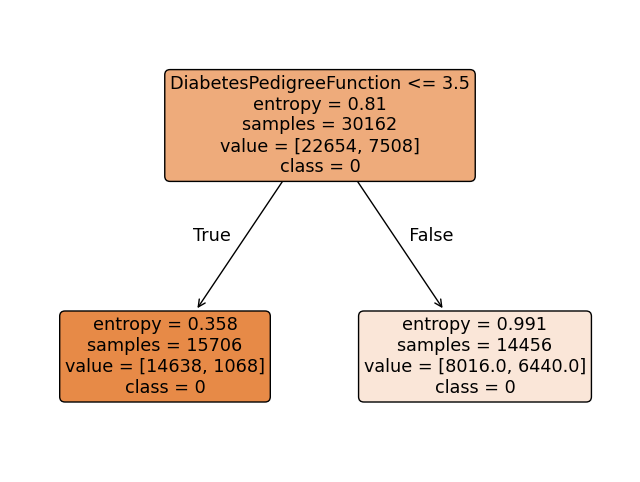

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
# Feature selection for the first step in making decision tree
selected_feature = 'DiabetesPedigreeFunction'

# Create a decision tree
clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)
X = data[['marital.status']]
y = data['income']
clf.fit(X, y)

plt.figure(figsize=(8, 6))
tree.plot_tree(clf, feature_names=[selected_feature], class_names=['0', '1'], filled=True, rounded=True)
plt.show()

###5.1.4 ID3 Algorithm

In [ ]:
def id3(data, target_column, features):
  # If there is only 1 value in the target column return that value
  if len(data[target_column].unique()) == 1:
    return data[target_column].iloc[0]

  # If no features it returns the most common value in target column
  if len(features) == 0:
    return data[target_column].mode().iloc[0]

  # Chooses which column produces the most information gain
  best_feature = max(features, key=lambda x: calculate_information_gain(data, x, target_column))
  # A dictionary that contains the best feature as the key and another dictionary as value
  tree = {best_feature: {}}

  # Extracts all the values not equal to the best feature
  features = [f for f in features if f != best_feature]

  # Iterate through each unique value in the best feature column
  for value in data[best_feature].unique():
      # Create a subset containing a selected unique value in
      # the best feature field
      subset = data[data[best_feature] == value]
      # Calls the function in a recursive manner and puts the result in the
      # tree dictionary
      tree[best_feature][value] = id3(subset, target_column, features)

  return tree

features = ['workclass','age','sex']
tree = id3(data, 'income', features)
print(tree)

{'age': {82: 0, 54: {'sex': {0: {'workclass': {0: 0, 3: 0, 1: 0, 5: 0, 2: 0}}, 1: {'workclass': {0: 1, 3: 0, 5: 0, 4: 1, 1: 1, 2: 1}}}}, 41: {'sex': {0: {'workclass': {0: 0, 4: 0, 2: 0, 3: 0, 5: 0, 1: 0}}, 1: {'workclass': {0: 0, 5: 0, 4: 1, 3: 0, 2: 1, 1: 0}}}}, 34: {'sex': {0: {'workclass': {0: 0, 3: 0, 5: 0, 4: 0, 1: 0, 2: 0}}, 1: {'workclass': {0: 0, 5: 0, 4: 0, 3: 0, 2: 0, 1: 0}}}}, 38: {'sex': {1: {'workclass': {0: 0, 3: 0, 2: 1, 5: 0, 4: 1, 1: 0}}, 0: {'workclass': {0: 0, 5: 0, 2: 0, 1: 0, 3: 0, 4: 0}}}}, 74: {'workclass': {1: {'sex': {0: 0, 1: 0}}, 3: {'sex': {1: 0, 0: 0}}, 0: {'sex': {1: 0, 0: 0}}, 4: {'sex': {1: 1}}, 2: 0}}, 68: {'sex': {0: {'workclass': {2: 0, 0: 0, 4: 0, 5: 0, 3: 0, 6: 0}}, 1: {'workclass': {0: 0, 1: 0, 3: 0, 5: 0, 4: 0}}}}, 45: {'sex': {0: {'workclass': {0: 0, 5: 0, 4: 0, 2: 0, 1: 0, 3: 0}}, 1: {'workclass': {0: 0, 2: 1, 5: 1, 1: 0, 3: 0, 4: 1}}}}, 52: {'sex': {0: {'workclass': {0: 0, 1: 0, 3: 0, 4: 1, 5: 0, 2: 0, 6: 0}}, 1: {'workclass': {0: 0, 5: 1, 4: 1

###5.1.5 Testing the Algorithm

In [ ]:
features = ['workclass']
tree = id3(data, 'income', features)
print(tree)

{'workclass': {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0}}


This means:
*   Since workclass is the only provided feature it is chosen as the best feature.
*   Category 4 which is self employed is the only one which has a mode value of 1 which means most of self employed people earned over 50k



##5.2 C4.5
C4.5 is an enhancement to the ID3 algorithm. This model solves several issues of ID3, namely the issue of overfitting and not being able to work with continuous characteristics. Instead of using the information gain metric, C4.5 uses a modification of it called the **gain ratio**. It addresses the bias towards qualities with many values. This type also support multi-way splits.

How it is able to work with continous values is, it sorts the columns values first and selects a midpoint between each value in the column. Then it calculates the gain ratio for each midpoint (**split point**). Then the midpoint with the highest gain ratio is selected, as a node. This process is repeated until you reach purity in all end nodes.

How it fixed the overfitting issue is through a process called **pruning**. How pruning works is when the tree is fully built the model checks if any branches can be removed without significantly affecting the models accuracy.

Note: I ran out of time to implement this variant.

##5.3 CART (Classification and Regression Trees)
CART is a type of decision tree that can handle both classification and regression tasks. It builds binary trees, which means a node can have only 2 branches. Scikit-Learn uses this algorithm for its model, but it only supports the use of numeric values even for categorical data. That is why I had to convert certain column values to numbers in the decision tree above. Also, it uses pruning similar to the C4.5 decision tree.

How CART works is by splitting the data into two parts depending on a feature that best separates the data. This feature changes depending on whether it's a classification or a regression task.

For classification tasks, a metric called **Gini impurity** is used. Gini impurity measures how pure a node is. CART tests all splits and chooses the one with the lowest Gini impurity.

For regression tasks, CART measures the average squared difference between the predicted values and actual ones, this is called . It selects the child node that has the largest reduction in the difference of those 2 values. This is called **Residual Reduction**.

I used these sources to learn more about this decision tree variant: [geeksforgeeks](https://www.geeksforgeeks.org/cart-classification-and-regression-tree-in-machine-learning/), as well as ChatGPT

You can view an example of me using this type of decision tree [here](#Decision-Tree-Algorithm-Section)



---

#**6. Random Forest**
Random Forests is a machine learning algorithm used for both regression and classification tasks. It is an ensemble method which combines the predictions from multiple decision trees.

In random forest multiple decision trees are created using different random subests of data. How predicitons are made for classification is by making a prediction for each decision tree and taking the most popular result. For regression it works similar but it just averages the result instead of taking the most popular one.

I used this resource for this section: [datacamp](https://www.datacamp.com/tutorial/random-forests-classifier-python?dc_referrer=https%3A%2F%2Fwww.google.com%2F) and ChatGPT

Below you can see me try this algorithm out on my dataset.

##6.1 Loading The Dataset

In [ ]:
data = pd.read_csv('adult-census-income/adult.csv')
data = prepareData(data)
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,0,132870,0,9,0,Exec-managerial,Not-in-family,White,0,0,4356,18,United-States,0
3,54,0,140359,1,4,1,Machine-op-inspct,Unmarried,White,0,0,3900,40,United-States,0
4,41,0,264663,2,10,2,Prof-specialty,Own-child,White,0,0,3900,40,United-States,0
5,34,0,216864,0,9,1,Other-service,Unmarried,White,0,0,3770,45,United-States,0
6,38,0,150601,3,6,2,Adm-clerical,Unmarried,White,1,0,3770,40,United-States,0


##6.2 Import Libraries

In [ ]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn import tree

# Tree Visualisation
import matplotlib.pyplot as plt

##6.3 Create Train/Test Sets

In [ ]:
x = data[['age','capital.loss', 'education']]
y = data['income']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x.shape)
print(X_train.shape)
print(X_test.shape)

(30162, 3)
(24129, 3)
(6033, 3)


##6.4 Creating Random Forest Model

In [ ]:
#Creates 100 decision trees in the random froest
#This is an example of a hyperparameter (a parameter used to control the
#learning process of the model)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7919774573180839


##6.5 Visualising The First Decision Tree

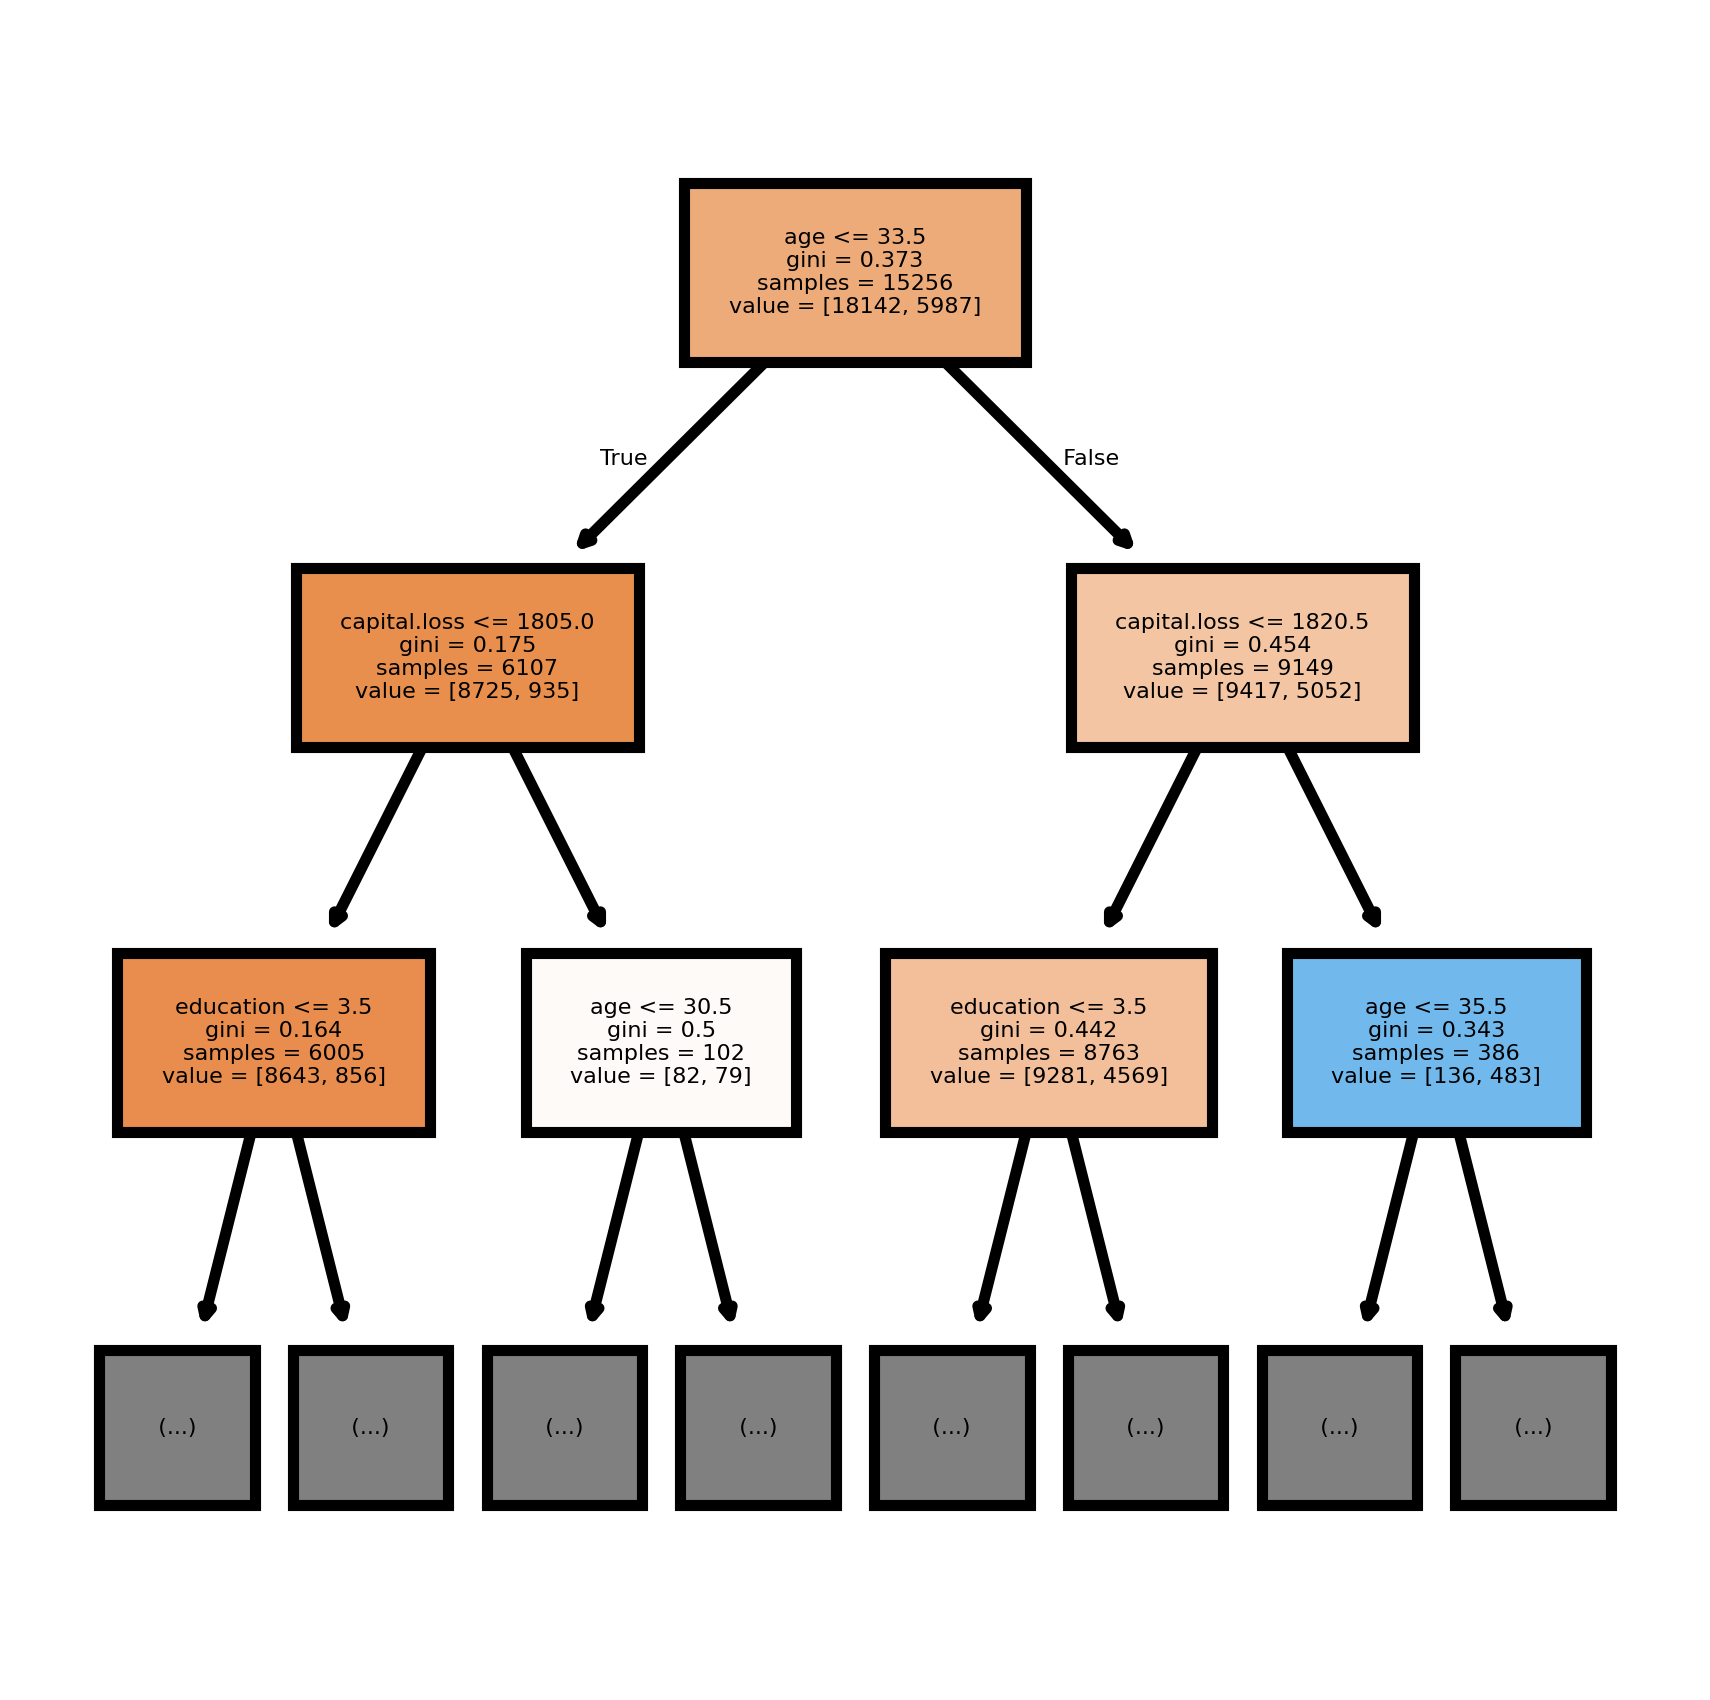

In [ ]:
features = ['age', 'capital.loss', 'education']
target = ['income']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (2.5,2.5), dpi=800)
tree.plot_tree(
      rf.estimators_[0],
      feature_names = features,
      filled = True,
      max_depth=2, #Made it 2 just so it'll be easier to look at
      fontsize=2
    );

As you can see I solved the issue of the tree being hard to read by limitting the amount of branches being shown.

##6.6 Visualising First 5 Decision Trees

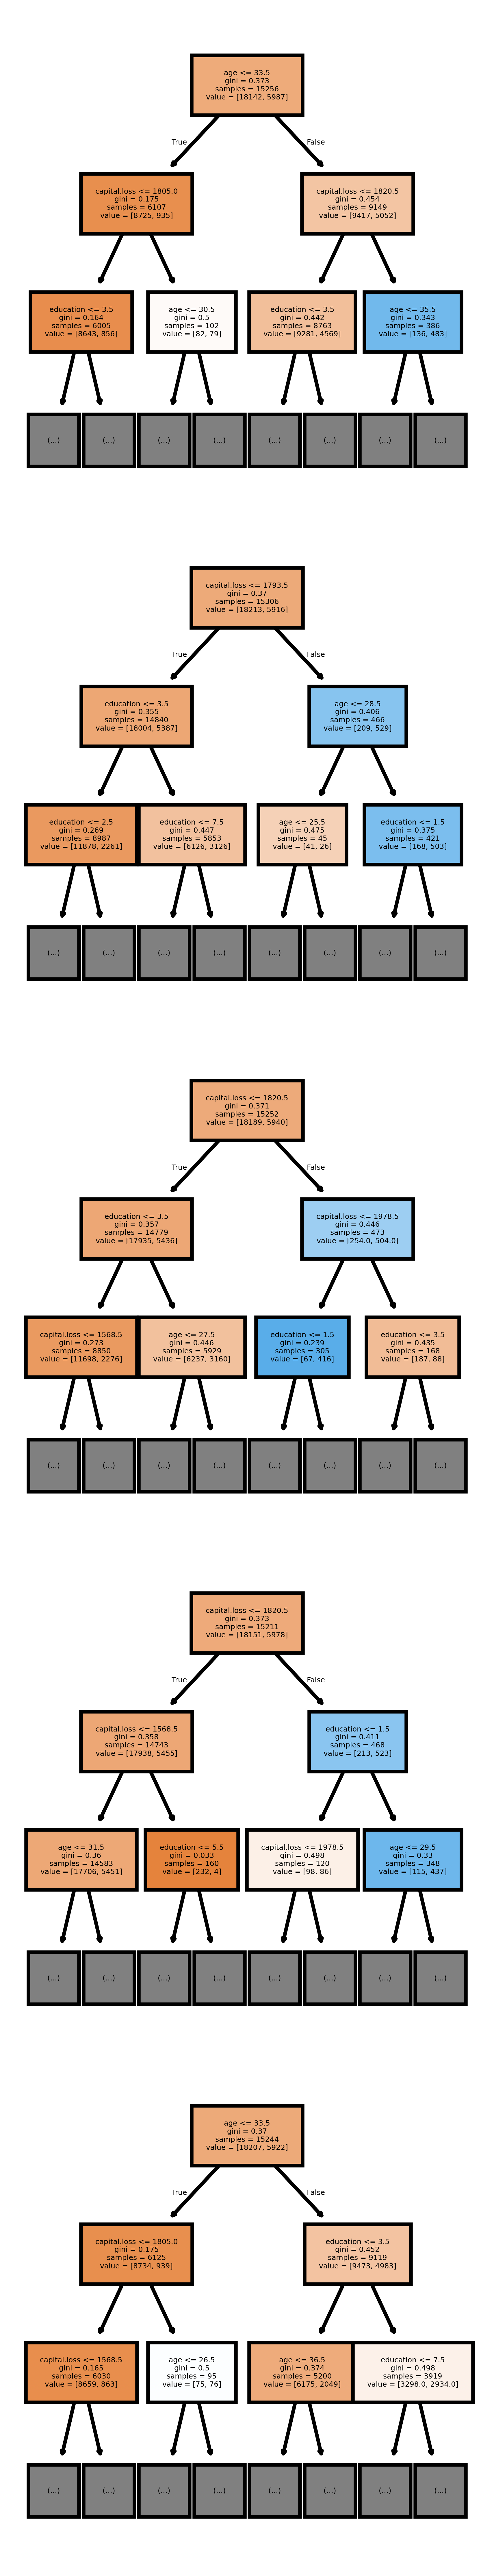

In [ ]:
fig, axes = plt.subplots(nrows = 5,ncols = 1,figsize = (2,10), dpi=900)
for i in range(0, 5):
  tree.plot_tree(
        rf.estimators_[i],
        feature_names = features,
        filled = True,
        max_depth=2, #Made it 2 just so it'll be easier to look at
        fontsize=2,
        ax = axes[i]
      );
plt.tight_layout()

##6.7 Confusion Matrix
Confusion Matrix is a matrix that is used to evaluate the performance of a certain model. It is often used for classification models.

It has 4 different categories:

1.   **True Positives**: Correct positive prediction so in this case it would be that the income was over 50k
2.   **True Negatives**: Correct negative prediction so in this case it would be that the income was under 50k
3.   **False Positives (Type I Error)**: Incorrect positive prediction
4.   **False Negatives (Type II Error)**: Incorrect Negative prediction



Resource for this section: [geeksforgeeks](https://www.geeksforgeeks.org/confusion-matrix-machine-learning/)

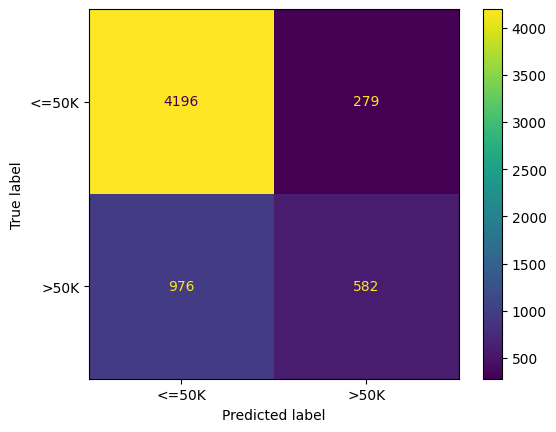

In [ ]:
y_pred = rf.predict(X_test)
labels = ["<=50K", ">50K"]
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels).plot();

*   Top-Left:     True Positive  -  4196
*   Top-Right:    False Negative -  279
*   Bottom-Left:  False Positive -  976
*   Bottom-Right: True Negative -   582
